In [13]:
import glob
import json
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

PATH = os.path.join(os.path.expanduser('~'), 'probspace-minpaku-pricing')
if PATH not in sys.path:
    sys.path.append(PATH)
from scripts.feature_engineering import LocationClustering

%matplotlib inline

## 前処理ネタ

1. `name` に含まれる情報はクレンジングしておきたい
1. `name` の埋め込みベクトル、文字列長さ、単語数
  - `name` の言語はほぼ日本語、英語、中国語。まれにハングルがあるが両の手にすら満たない数かも。
  - FastText の言語識別モデルの結果は信用できそう。日本語英語中国語以外は英語で処理する。ハングルは90%超えたら信用できそうだ数は少ない。
  - [このノート](notebooks/nameって何語なの？.ipynb)
1. 今のレビュー数を得るのに何か月かかったのか
1. `host_id` のエンコーディング
    1. Frequency encoding
    1. レビュー履歴を集計する
    1. Cross table 集計で持っている物件の特徴を定量化（`neighbourhood`, `room_type` あたりがよさそう）
1. 最寄り駅 Top $N$ の名前と距離
    1. 駅名の重複に注意
    1. "押上（スカイツリー前）"、押上〈スカイツリー前〉の2つが存在するので注意（経度緯度は同じなので削除）
1. 経度緯度
    1. クラスタリングしてセントロイドからの距離を測る（場所が個性的度）
      - 多分クラスタ数は 9, 10 がちょうど良さそう
    1. 自身から $N$ の距離内の駅数（利便性の尺度？）
    1. 自身から $N$ の距離内の民泊数（競争過密度？）

1. 同じ価格の民泊がたくさんありそう？調べてみる。


## やってみたいこと

|No|CV|
|---:|:---|
|1|特徴量：`neighbourhood`, `latitude`, `longitude`, `room_type`, `minimum_nights`, `number_of_reviews`, `reviews_per_month`, `availability_365`, `review_date`, CV: StratifiedKfold(`neighborhood`), モデル：CatBoost|v
|2|特徴量：2 + `name` を train と test で共有されていなければ専用の値でマスク, CV: StratifiedKfold(`neighborhood`), モデル：CatBoost|
|3|特徴量：2 + `name` を Tf-IDF+LSIで64次元のベクトルに 
|4|特徴量：2 + `name` を Tf-IDF+LDAで64次元のベクトルに 
|5|特徴量：2 + `name` を Tf-IDF+NMFで64次元のベクトルに
|6|特徴量：2 + `name` を Tf-IDF+LSIで32次元のベクトルに 
|7|特徴量：2 + `name` を Tf-IDF+LDAで32次元のベクトルに 
|8|特徴量：2 + `name` を Tf-IDF+NMFで32次元のベクトルに
|9|特徴量：2 + `name` を Tf-IDF+LSIで16次元のベクトルに 
|10|特徴量：2 + `name` を Tf-IDF+LDAで16次元のベクトルに 
|11|特徴量：2 + `name` を Tf-IDF+NMFで16次元のベクトルに
|12|No.3 の Fold を StratifiedKFold(`y`を binning したやつ) + `name` はクレンジング|
|13|No.3 の Fold を GroupKFold(`host_id`)+ `name` はクレンジング|
|14|No.5 の Fold を StratifiedKFold(`y`を binning したやつ)+ `name` はクレンジング|
|15|No.5 の Fold を GroupKFold(`host_id`)+ `name` はクレンジング|
|16|No.6 の Fold を StratifiedKFold(`y`を binning したやつ)+ `name` はクレンジング|
|17|No.6 の Fold を GroupKFold(`host_id`)+ `name` はクレンジング|
|18|No.8 の Fold を StratifiedKFold(`y`を binning したやつ)+ `name` はクレンジング|
|19|No.8 の Fold を GroupKFold(`host_id`)+ `name` はクレンジング|
|20|No.5 に `name` のクレンジングを忘れていたので追加|
|21|No.20 に今のレビュー数を得るのに何か月かかったのかの特徴量を追加|
|22|No.14 に今のレビュー数を得るのに何か月かかったのかの特徴量を追加|
|23|No.15 に今のレビュー数を得るのに何か月かかったのかの特徴量を追加|
|24|No.20 にクラスタリングの特徴量を追加|
|25|No.14 にクラスタリングの特徴量を追加|
|26|No.15 にクラスタリングの特徴量を追加|
|27|No.20 に最寄り駅の特徴量を追加|
|28|No.14 に最寄り駅の特徴量を追加|
|29|No.15 に最寄り駅の特徴量を追加|
|30|No.20 に近くの民泊数の特徴量を追加|
|31|No.14 に近くの民泊数の特徴量を追加|
|32|No.15 に近くの民泊数の特徴量を追加|
|33|No.2 に `name` のクレンジング + BERTベクトル化した結果を追加 + Fold は StratifiedKFold(`neighbourhood`)|
|34|No.2 に `name` のクレンジング + BERTベクトル化した結果を追加 + Fold は StratifiedKFold(`y`を binning したやつ)|
|35|No.2 に `name` のクレンジング + BERTベクトル化した結果を追加 + Fold は GroupKFold(`host_id`)|
|36|No.2 に `name` のクレンジング + FastText による言語予測結果 + 言語に応じた BERT によるベクトル化 + Fold は StratifiedKFold(`neighbourhood`)|
|37|No.2 に `name` のクレンジング + FastText による言語予測結果 + 言語に応じた BERT によるベクトル化 + Fold は StratifiedKFold(`y`を binning したやつ)|
|38|No.2 に `name` のクレンジング + FastText による言語予測結果 + 言語に応じた BERT によるベクトル化 + Fold は GroupKFold(`host_id`)|
|39|No.2 に `name` のクレンジング + FastText による言語予測結果 + 言語に応じた形態素解析 + NMFで64次元に + Fold は StratifiedKFold(`neighbourhood`)|
|40|No.2 に `name` のクレンジング + FastText による言語予測結果 + 言語に応じた形態素解析 + NMFで64次元に + Fold は StratifiedKFold(`y`を binning したやつ)|
|41|No.2 に `name` のクレンジング + FastText による言語予測結果 + 言語に応じた形態素解析 + NMFで64次元に+ Fold は GroupKFold(`host_id`)|
|42|No.2 に `name` のクレンジング + FastText による言語予測結果 + 言語に応じた形態素解析 + LSIで64次元に + Fold は StratifiedKFold(`neighbourhood`)|
|43|No.2 に `name` のクレンジング + FastText による言語予測結果 + 言語に応じた形態素解析 + LSIで64次元に + Fold は StratifiedKFold(`y`を binning したやつ)|
|44|No.2 に `name` のクレンジング + FastText による言語予測結果 + 言語に応じた形態素解析 + LSIで64次元に+ Fold は GroupKFold(`host_id`)|

2022-04-28

No.11 まで実施するも CV vs LB の並びが気に食わない。相関は強そうだがロスに差があるのはさておき順位が一致しないのが気持ち悪い
StratifiedKFold(`neighbourhood`)以外の方法も試して信頼できる CV を探したい。No.3, 5, 6, 8 を対象に以下を試す。

- StratifiedKFold: `y`を binning して bin を層とみなす
- GroupKFold(`host_id`): [このDiscussion](https://comp.probspace.com/competitions/bnb_price/discussions/shirapon24-Postde0ee1e20bc5d402eea0) でやってる人がいる。


2022-04-30

No.12-19 を行い5サブ使って CV と LB の相関を確認する。相関はしているが CV と LB とで順位が合わないことがあり気持ち悪い。

No.44 までつらつらと書き連ねた。今のレビュー数を得るのに何か月かかったのかの特徴量は無い方が良い？同じ `name` で場所も同じっぽいのに `host_id` が違うと価格が大きく変わることがある。`host_id` から予測に役立つ情報をどう抽出するのか？を考えられたらスコア大きく伸びるかも？

No.19 以降は表の番号と実際のノートがあっていないかもしれないから要チェック。

In [14]:
%%time
!jupyter nbconvert --to notebook --execute notebooks\021.ipynb --debug --inplace --ExecutePreprocessor.timeout=2678400

CPU times: total: 15.6 ms
Wall time: 3min 15s


[NbConvertApp] Searching ['C:\\Users\\nndropout\\probspace-minpaku-pricing', 'C:\\Users\\nndropout\\.jupyter', 'C:\\Users\\nndropout\\probspace-minpaku-pricing\\.venv\\etc\\jupyter', 'C:\\ProgramData\\jupyter'] for config files
[NbConvertApp] Looking for jupyter_config in C:\ProgramData\jupyter
[NbConvertApp] Looking for jupyter_config in C:\Users\nndropout\probspace-minpaku-pricing\.venv\etc\jupyter
[NbConvertApp] Looking for jupyter_config in C:\Users\nndropout\.jupyter
[NbConvertApp] Looking for jupyter_config in C:\Users\nndropout\probspace-minpaku-pricing
[NbConvertApp] Looking for jupyter_nbconvert_config in C:\ProgramData\jupyter
[NbConvertApp] Looking for jupyter_nbconvert_config in C:\Users\nndropout\probspace-minpaku-pricing\.venv\etc\jupyter
[NbConvertApp] Looking for jupyter_nbconvert_config in C:\Users\nndropout\.jupyter
[NbConvertApp] Loaded config file: C:\Users\nndropout\.jupyter\jupyter_nbconvert_config.json
[NbConvertApp] Looking for jupyter_nbconvert_config in C:\Use

In [15]:
%%time
!jupyter nbconvert --to notebook --execute notebooks\022.ipynb --debug --inplace --ExecutePreprocessor.timeout=2678400

CPU times: total: 93.8 ms
Wall time: 3min 41s


[NbConvertApp] Searching ['C:\\Users\\nndropout\\probspace-minpaku-pricing', 'C:\\Users\\nndropout\\.jupyter', 'C:\\Users\\nndropout\\probspace-minpaku-pricing\\.venv\\etc\\jupyter', 'C:\\ProgramData\\jupyter'] for config files
[NbConvertApp] Looking for jupyter_config in C:\ProgramData\jupyter
[NbConvertApp] Looking for jupyter_config in C:\Users\nndropout\probspace-minpaku-pricing\.venv\etc\jupyter
[NbConvertApp] Looking for jupyter_config in C:\Users\nndropout\.jupyter
[NbConvertApp] Looking for jupyter_config in C:\Users\nndropout\probspace-minpaku-pricing
[NbConvertApp] Looking for jupyter_nbconvert_config in C:\ProgramData\jupyter
[NbConvertApp] Looking for jupyter_nbconvert_config in C:\Users\nndropout\probspace-minpaku-pricing\.venv\etc\jupyter
[NbConvertApp] Looking for jupyter_nbconvert_config in C:\Users\nndropout\.jupyter
[NbConvertApp] Loaded config file: C:\Users\nndropout\.jupyter\jupyter_nbconvert_config.json
[NbConvertApp] Looking for jupyter_nbconvert_config in C:\Use

In [16]:
%%time
!jupyter nbconvert --to notebook --execute notebooks\023.ipynb --debug --inplace --ExecutePreprocessor.timeout=2678400

CPU times: total: 31.2 ms
Wall time: 3min 51s


[NbConvertApp] Searching ['C:\\Users\\nndropout\\probspace-minpaku-pricing', 'C:\\Users\\nndropout\\.jupyter', 'C:\\Users\\nndropout\\probspace-minpaku-pricing\\.venv\\etc\\jupyter', 'C:\\ProgramData\\jupyter'] for config files
[NbConvertApp] Looking for jupyter_config in C:\ProgramData\jupyter
[NbConvertApp] Looking for jupyter_config in C:\Users\nndropout\probspace-minpaku-pricing\.venv\etc\jupyter
[NbConvertApp] Looking for jupyter_config in C:\Users\nndropout\.jupyter
[NbConvertApp] Looking for jupyter_config in C:\Users\nndropout\probspace-minpaku-pricing
[NbConvertApp] Looking for jupyter_nbconvert_config in C:\ProgramData\jupyter
[NbConvertApp] Looking for jupyter_nbconvert_config in C:\Users\nndropout\probspace-minpaku-pricing\.venv\etc\jupyter
[NbConvertApp] Looking for jupyter_nbconvert_config in C:\Users\nndropout\.jupyter
[NbConvertApp] Loaded config file: C:\Users\nndropout\.jupyter\jupyter_nbconvert_config.json
[NbConvertApp] Looking for jupyter_nbconvert_config in C:\Use

## CV vs LB

In [17]:
lb = [
    ('001', 0.86378),
    ('002', np.nan),  # `y` を対数変換せずに学習して Submit したので他と比べられない
    ('003', 0.82206),
    ('004', 0.85716),
    ('005', 0.80957),
    ('006', 0.82747),
    ('007', 0.84814),
    ('008', 0.82104),
    ('009', 0.83919),
    ('010', 0.86311),
    ('011', 0.83046),
    ('012', 0.82092),
    ('013', 0.82579),
    ('014', 0.80827),
    ('015', 0.80948),
    ('016', 0.82307),
    ('017', 0.83054),
    ('018', 0.81970),
    ('019', 0.82118),
    ('020', 0.80767),
    ('021', 0.80968)

]
lb = pd.DataFrame(lb, columns=['No', 'LB'])
assert not lb['No'].duplicated().any()
lb

,No,LB
0,001,0.86378
1,002,NaN
2,003,0.82206
3,004,0.85716
4,005,0.80957
5,006,0.82747
6,007,0.84814
7,008,0.82104
8,009,0.83919
9,010,0.86311


In [18]:
pd.read_csv(r"C:\Users\nndropout\dataset\probspace\minpaku-pricing\train_data.csv")

,id,name,host_id,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,availability_365,y
0,1,KiyosumiShirakawa 3min|★SkyTree★|WIFI|Max4|Tre...,242899459,Koto Ku,35.68185,139.80310,Entire home/apt,1,55,2020-04-25,2.21,173,12008
1,2,Downtown Tokyo Iriya next to Ueno,308879948,Taito Ku,35.72063,139.78536,Entire home/apt,6,72,2020-03-25,2.11,9,6667
2,3,"Japan Style,Private,Affordable,4min to Sta.",300877823,Katsushika Ku,35.74723,139.82349,Entire home/apt,1,18,2020-03-23,3.46,288,9923
3,4,4 min to Shinjuku Sta. by train / 2 ppl / Wi-fi,236935461,Shibuya Ku,35.68456,139.68077,Entire home/apt,1,2,2020-04-02,1.76,87,8109
4,5,LICENSED SHINJUKU HOUSE: Heart of the action!,243408889,Shinjuku Ku,35.69840,139.70467,Entire home/apt,1,86,2020-01-30,2.00,156,100390
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,9986,Shinjuku Kabukicho2 / Shinjuku 3min walk,59104733,Shinjuku Ku,35.69728,139.70321,Entire home/apt,1,1,2019-12-09,0.21,357,13505
9986,9987,Hostel just 1 min from Sta. / Dorm with curtain,131595566,Taito Ku,35.70407,139.79180,Shared room,1,0,NaN,NaN,153,3279
9987,9988,Hostel just 5 min from Sta./4 bed room with bath,147026065,Taito Ku,35.71501,139.79417,Private room,1,5,2019-12-10,0.22,156,14898
9988,9989,SHITARA HOUSE dormitory B,316273494,Katsushika Ku,35.74672,139.82925,Shared room,1,1,2020-01-01,0.25,0,3950


In [19]:
cv = []
for filepath in glob.glob(os.path.join('notebooks', '*', 'result.json')):
    with open(filepath, 'r') as f:
        cv.append(json.load(f))
cv = pd.DataFrame(cv)
cv

,No,CV,Fold
0,001,0.694386,NaN
1,002,0.697720,NaN
2,003,0.589649,NaN
3,004,0.667733,NaN
4,005,0.590896,NaN
5,006,0.600847,NaN
6,007,0.674444,NaN
7,008,0.604754,NaN
8,009,0.610643,NaN
9,010,0.677813,NaN


In [20]:
cv_vs_lb = pd.merge(cv, lb, how='left').set_index('No')
cv_vs_lb['Fold'].fillna('StratifiedKFold(neighbourhood)', inplace=True)
cv_vs_lb['Rank(CV)'] = cv_vs_lb['CV'].rank().astype('int')
cv_vs_lb['Rank(LB)'] = cv_vs_lb['LB'].rank()
cv_vs_lb = cv_vs_lb[['Fold', 'CV', 'LB', 'Rank(CV)', 'Rank(LB)']]
cv_vs_lb.sort_values(['Fold', 'Rank(CV)'])

,Fold,CV,LB,Rank(CV),Rank(LB)
No,,,,,
015,GroupKFold(host_id),0.808273,0.80948,19,3.0
023,GroupKFold(host_id),0.820614,NaN,20,NaN
017,GroupKFold(host_id),0.825099,0.83054,21,14.0
013,GroupKFold(host_id),0.830990,0.82579,22,11.0
019,GroupKFold(host_id),0.831398,0.82118,23,8.0
003,StratifiedKFold(neighbourhood),0.589649,0.82206,2,9.0
005,StratifiedKFold(neighbourhood),0.590896,0.80957,3,4.0
021,StratifiedKFold(neighbourhood),0.592339,NaN,4,NaN
020,StratifiedKFold(neighbourhood),0.592780,0.80767,5,1.0


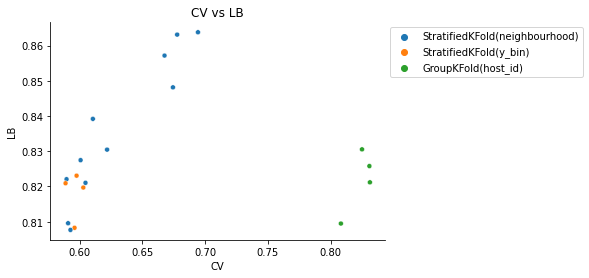

In [21]:
fig, _ = plt.subplots(nrows=1, ncols=1, sharex=True,sharey=True)
ax = sns.scatterplot(data=cv_vs_lb, x='CV', y='LB', hue='Fold', s=24)
ax.legend(loc='upper left', bbox_to_anchor=[1., 1.])
ax.set_title('CV vs LB')
sns.despine()

In [22]:
cv_vs_lb.groupby('Fold').corr()

CV        LB  Rank(CV)  \
Fold                                                                    
GroupKFold(host_id)            CV        1.000000  0.772525  0.942491   
                               LB        0.772525  1.000000  0.593352   
                               Rank(CV)  0.942491  0.593352  1.000000   
                               Rank(LB)  0.698215  0.993686  0.499350   
StratifiedKFold(neighbourhood) CV        1.000000  0.935974  0.897254   
                               LB        0.935974  1.000000  0.871399   
                               Rank(CV)  0.897254  0.871399  1.000000   
                               Rank(LB)  0.834510  0.953570  0.847781   
StratifiedKFold(y_bin)         CV        1.000000 -0.007198  0.974966   
                               LB       -0.007198  1.000000 -0.095700   
                               Rank(CV)  0.974966 -0.095700  1.000000   
                               Rank(LB) -0.002803  0.875063  0.013024   

                                         Rank(LB)  
Fold                                               
GroupKFold(host_id)            CV        0.698215  
                               LB        0.993686  
                               Rank(CV)  0.499350  
                               Rank(LB)  1.000000  
StratifiedKFold(neighbourhood) CV        0.834510  
                               LB        0.953570  
                               Rank(CV)  0.847781  
                               Rank(LB)  1.000000  
StratifiedKFold(y_bin)         CV       -0.002803  
                               LB        0.875063  
                               Rank(CV)  0.013024  
                               Rank(LB)  1.000000

## Submissions

In [23]:
submissions = []
for filepath in glob.glob(os.path.join('notebooks', '*', 'submission*.csv')):
    sub = pd.read_csv(filepath).set_index('id').rename(columns={'y': os.path.basename(filepath).replace('.csv', '')})
    submissions.append(sub)
submissions = pd.concat(submissions, axis=1)
submissions

,submission_001,submission_002,submission_003,submission_004,submission_005,submission_006,submission_007,submission_008,submission_009,submission_010,...,submission_014,submission_015,submission_016,submission_017,submission_018,submission_019,submission_020,submission_021,submission_022,submission_023
id,,,,,,,,,,,,,,,,,,,,,
1,15563.757288,15412.997055,15149.523135,13178.117184,11980.825061,10508.393906,15667.459837,11324.098572,12065.894615,14905.229225,...,14154.321140,16046.188072,10199.773773,10798.421583,11107.227526,12057.404934,16418.334961,14659.258931,15246.903720,14419.796093
2,11315.311473,11800.884838,16759.002170,18896.921538,17543.344321,18547.891042,15522.055171,19381.293858,13768.671233,13016.722028,...,18915.988023,18757.732832,16369.090262,19235.375734,16490.337661,17449.632198,19956.802988,17869.436137,20573.407248,17316.461720
3,15921.739860,15458.861373,12868.850477,13833.183047,8661.947943,14978.764058,14609.431020,12749.191746,14776.633311,13855.485504,...,12383.932635,11853.385724,15626.689486,15218.978169,13305.617657,12110.066890,10810.736472,10402.598176,11505.213873,10738.058366
4,18301.790676,17935.568540,18215.072414,18200.361440,13063.205844,17165.856038,13294.381434,11831.085654,13983.897808,16297.975643,...,12954.097173,12941.253911,17508.600038,16571.300060,12051.760442,12037.040091,12868.143495,12729.281578,12774.948521,12778.420779
5,16902.712775,17462.485144,13713.515681,10807.210259,17727.311670,16046.239749,10672.610902,19578.740872,13694.180372,12693.326009,...,14898.491571,15553.146837,18118.603012,17442.745193,20704.714180,18086.764693,15559.771680,16970.595064,16004.686213,15800.878805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4992,16205.214315,17100.410596,16314.733135,15171.650792,19556.640976,14094.964825,16362.980911,13140.105071,13840.264147,15989.095466,...,21903.719987,19638.712938,13707.809153,13427.693071,13132.744460,13942.021092,21562.783316,21465.250366,21895.346784,20381.007759
4993,5677.865217,5358.291104,5948.367432,3948.394058,7428.852594,5898.345846,4168.222473,5514.551350,5488.185618,4596.088497,...,6326.470664,6936.332639,6212.077528,6625.389730,5861.678226,5543.273049,6555.000555,6638.397393,6754.151453,6931.101749
4994,12993.019405,13360.993708,12191.612305,8989.510602,9128.376238,10654.646137,14195.483591,13188.754774,9980.230906,14370.268756,...,8530.740472,7528.721865,10571.509269,9881.171152,12845.965273,12706.124458,8068.142350,7934.189612,8716.376193,8015.135094


In [24]:
corr = submissions.corr()
corr

,submission_001,submission_002,submission_003,submission_004,submission_005,submission_006,submission_007,submission_008,submission_009,submission_010,...,submission_014,submission_015,submission_016,submission_017,submission_018,submission_019,submission_020,submission_021,submission_022,submission_023
submission_001,1.000000,0.992997,0.636294,0.709383,0.539525,0.626795,0.742152,0.614587,0.669529,0.777660,...,0.559345,0.579494,0.630332,0.624407,0.623208,0.621060,0.548049,0.554412,0.555348,0.603576
submission_002,0.992997,1.000000,0.638716,0.713171,0.538779,0.627931,0.746296,0.615483,0.670174,0.781966,...,0.560348,0.581401,0.630810,0.626237,0.623257,0.622510,0.548326,0.555130,0.556170,0.605280
submission_003,0.636294,0.638716,1.000000,0.745140,0.703509,0.924160,0.729231,0.812588,0.885452,0.726250,...,0.729803,0.742276,0.920851,0.901513,0.820796,0.822683,0.721538,0.715478,0.724692,0.768025
submission_004,0.709383,0.713171,0.745140,1.000000,0.599688,0.734037,0.872784,0.685876,0.737677,0.882376,...,0.623477,0.650809,0.734976,0.727150,0.692181,0.706578,0.612994,0.608443,0.618332,0.668959
submission_005,0.539525,0.538779,0.703509,0.599688,1.000000,0.672951,0.584961,0.826826,0.640432,0.607285,...,0.964817,0.955737,0.676348,0.681868,0.841018,0.801385,0.962988,0.960770,0.966684,0.951876
submission_006,0.626795,0.627931,0.924160,0.734037,0.672951,1.000000,0.724703,0.820976,0.932568,0.725500,...,0.702941,0.721062,0.991575,0.977595,0.824287,0.835714,0.692099,0.686112,0.699184,0.744082
submission_007,0.742152,0.746296,0.729231,0.872784,0.584961,0.724703,1.000000,0.681112,0.736974,0.890258,...,0.603864,0.630911,0.726606,0.711958,0.688216,0.700881,0.594114,0.592483,0.603024,0.651987
submission_008,0.614587,0.615483,0.812588,0.685876,0.826826,0.820976,0.681112,1.000000,0.787521,0.692764,...,0.856165,0.865592,0.822782,0.828437,0.990449,0.975588,0.849883,0.847927,0.851426,0.867106
submission_009,0.669529,0.670174,0.885452,0.737677,0.640432,0.932568,0.736974,0.787521,1.000000,0.747692,...,0.672810,0.695406,0.931974,0.923109,0.793233,0.813450,0.660106,0.656535,0.670022,0.721166
submission_010,0.777660,0.781966,0.726250,0.882376,0.607285,0.725500,0.890258,0.692764,0.747692,1.000000,...,0.636504,0.658698,0.725685,0.720701,0.699475,0.707004,0.626227,0.626529,0.636116,0.674411


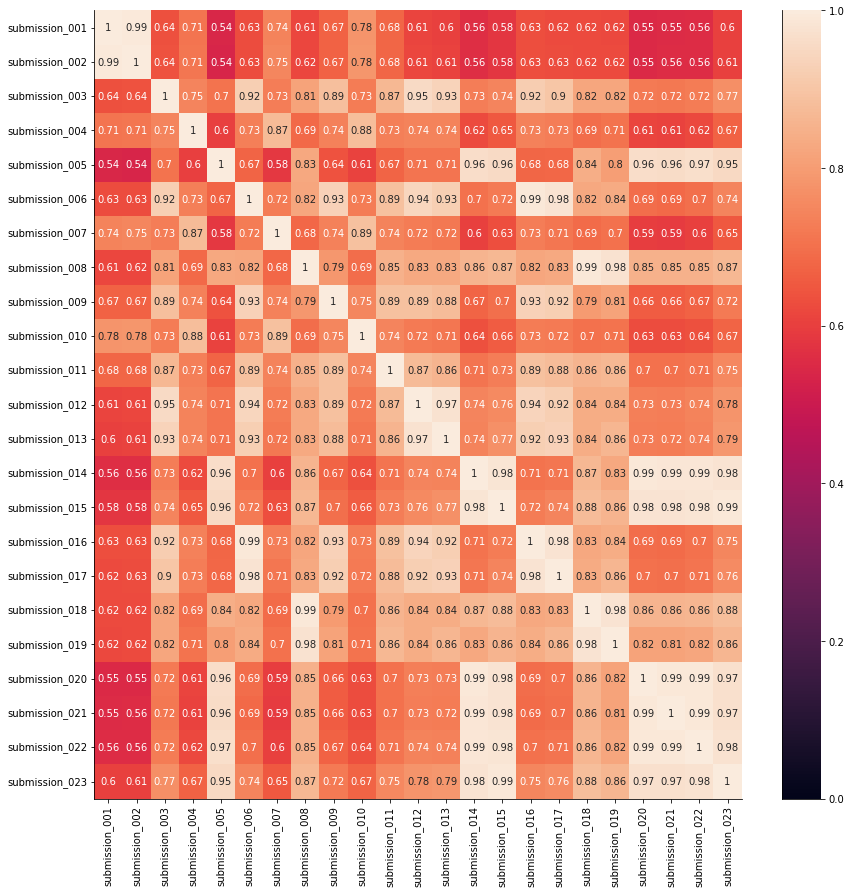

In [25]:
fig = plt.figure(figsize=(14.5, 14.5))
sns.heatmap(corr, annot=True, vmin=0., vmax=1.)
sns.despine()